# N-Gram

We'll assume that our text is already "tokenized" (split up into words). We'll cover this process in more depth in the next module.

As an example, let's work with two sentences from "[The Disappearance of Lady Frances Carfax](https://en.wikipedia.org/wiki/The_Disappearance_of_Lady_Frances_Carfax)", a short story written by [Sir Arthur Conan Doyle](https://en.wikipedia.org/wiki/Arthur_Conan_Doyle).

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Tokens for the sentence "It shows, my dear Watson, that we are dealing
# with an exceptionally astute and dangerous man."
sample1 = ['It', 'shows', ',', 'my', 'dear', 'Watson', ',', 'that',
           'we', 'are', 'dealing', 'with', 'an', 'exceptionally',
           'astute', 'and', 'dangerous', 'man', '.']
# Tokens for the sentence "How would Lausanne do, my dear Watson?"
sample2 = ['How', 'would', 'Lausanne', 'do', ',', 'my', 'dear',
           'Watson', '?']

Your first task is to write a function that splits the `tokens` sequence
into its `n`-grams.

For instance, when `tokens=sample1` and `n=3`, your function should
return:

```python
[('It', 'shows', ','),
 ('shows', ',', 'my'),
 (',', 'my', 'dear'),
 ...,
 ('dangerous', 'man', '.')]
```
 
Note: You should return a python [`list`](https://docs.python.org/3/tutorial/datastructures.html#more-on-lists) containing [`tuple`](https://docs.python.org/3/tutorial/datastructures.html#tuples-and-sequences)s. `tuple`s are immutable sequences, which will be useful later on when you build your language model.

In [3]:
from typing import List, Tuple


def build_ngrams(tokens: List[str], n: int) -> List[Tuple[str]]:
    """
    Build n-grams from a list of tokens.

    Args:
        tokens (List[str]): List of tokens.
        n (int): The size of the n-grams.

    Returns:
        List[Tuple[str]]: List of n-grams as tuples.
    """
    return [tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)]


# Example:
build_ngrams(sample1, n=2)

[('It', 'shows'),
 ('shows', ','),
 (',', 'my'),
 ('my', 'dear'),
 ('dear', 'Watson'),
 ('Watson', ','),
 (',', 'that'),
 ('that', 'we'),
 ('we', 'are'),
 ('are', 'dealing'),
 ('dealing', 'with'),
 ('with', 'an'),
 ('an', 'exceptionally'),
 ('exceptionally', 'astute'),
 ('astute', 'and'),
 ('and', 'dangerous'),
 ('dangerous', 'man'),
 ('man', '.')]

In [4]:
# Tests:
assert len(build_ngrams(sample1, n=3)) == 17
assert build_ngrams(sample1, n=3)[0] == ('It', 'shows', ',')
assert build_ngrams(sample1, n=3)[10] == ('dealing', 'with', 'an')
assert len(build_ngrams(sample1, n=2)) == 18
assert build_ngrams(sample1, n=2)[0] == ('It', 'shows')
assert build_ngrams(sample1, n=2)[10] == ('dealing', 'with')
assert len(build_ngrams(sample2, n=2)) == 8
assert build_ngrams(sample2, n=2)[0] == ('How', 'would')

With the current function, there's no way to know whether an n-gram is at the beginning, middle, or end of the sequence. To overcome this problem, n-gram language models often include special "beginning-of-string" (BOS) and "end-of-string" (EOS) control tokens.

Write a new version of your `build_ngrams` function that includes these control tokens. For instance, when `tokens=sample1` and `n=3`, your new function should return:

```python
[('<BOS>', '<BOS>', 'It'),
 ('<BOS>', 'It', 'shows'),
 ('It', 'shows', ','),
 ('shows', ',', 'my'),
 (',', 'my', 'dear'),
 ...,
 ('dangerous', 'man', '.'),
 ('man', '.', '<EOS>'),
 ('.', '<EOS>', '<EOS>')]
```

In [5]:
BOS = '<BOS>'
EOS = '<EOS>'


def build_ngrams_ctrl(tokens: List[str], n: int) -> List[Tuple[str]]:
    """
    Build n-grams from a list of tokens, including control tokens.

    Args:
        tokens (List[str]): List of tokens.
        n (int): The size of the n-grams.

    Returns:
        List[Tuple[str]]: List of n-grams as tuples with control tokens.
    """
    # Add control tokens
    tokens = [BOS] * (n - 1) + tokens + [EOS] * (n - 1)
    return build_ngrams(tokens, n)


# Example:
build_ngrams_ctrl(sample1, n=3)

[('<BOS>', '<BOS>', 'It'),
 ('<BOS>', 'It', 'shows'),
 ('It', 'shows', ','),
 ('shows', ',', 'my'),
 (',', 'my', 'dear'),
 ('my', 'dear', 'Watson'),
 ('dear', 'Watson', ','),
 ('Watson', ',', 'that'),
 (',', 'that', 'we'),
 ('that', 'we', 'are'),
 ('we', 'are', 'dealing'),
 ('are', 'dealing', 'with'),
 ('dealing', 'with', 'an'),
 ('with', 'an', 'exceptionally'),
 ('an', 'exceptionally', 'astute'),
 ('exceptionally', 'astute', 'and'),
 ('astute', 'and', 'dangerous'),
 ('and', 'dangerous', 'man'),
 ('dangerous', 'man', '.'),
 ('man', '.', '<EOS>'),
 ('.', '<EOS>', '<EOS>')]

In [6]:
# Tests:
assert len(build_ngrams_ctrl(sample1, n=3)) == 21
assert build_ngrams_ctrl(sample1, n=3)[0] == ('<BOS>', '<BOS>', 'It')
assert build_ngrams_ctrl(sample1, n=3)[10] == ('we', 'are', 'dealing')
assert len(build_ngrams_ctrl(sample1, n=2)) == 20
assert build_ngrams_ctrl(sample1, n=2)[0] == ('<BOS>', 'It')
assert build_ngrams_ctrl(sample1, n=2)[10] == ('are', 'dealing')
assert len(build_ngrams_ctrl(sample2, n=2)) == 10
assert build_ngrams_ctrl(sample2, n=2)[0] == ('<BOS>', 'How')
assert build_ngrams_ctrl(sample2, n=2)[9] == ('?', '<EOS>')

Now that you can build n-grams, we have almost everything we need to build an n-gram language model.

To compute Maximum Likelihood Estimations, you first need to count the number of times each word follows an n-gram of size `n-1`. You can build this structure as a Python [`dict`](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) that maps the n-grams of size `n-1` to another `dict` that maps the following words to their respective counts.

For instance, when `texts=[sample1, sample2]` and `n=3`, your function should return:

```python
{
    ('<BOS>', '<BOS>'): {'It': 1, 'How': 1},
    ('<BOS>', 'It'): {'shows': 1},
    ('<BOS>', 'How'): {'would': 1},
    ...
    ('my', 'dear'): {'Watson': 2},
    ('dear', 'Watson'): {',': 1, '?': 1},
    ...
}
```

In [7]:
from typing import Dict


def count_ngrams(texts: List[List[str]], n: int) -> Dict[Tuple[str, ...], Dict[str, int]]:
    """
    Count n-grams from a list of tokenized texts.

    Args:
        texts (List[List[str]]): List of tokenized texts.
        n (int): The size of the n-grams.

    Returns:
        Dict[Tuple[str, ...], Dict[str, int]]: Dictionary mapping n-grams to their counts.
    """
    ngram_counts = {}

    for tokens in texts:
        ngrams = build_ngrams_ctrl(tokens, n)
        for ngram in ngrams:
            last_word = ngram[-1]
            key = ngram[:-1]
            ngram_count = ngram_counts.get(key, {})
            ngram_count[last_word] = ngram_count.get(last_word, 0) + 1
            ngram_counts[key] = ngram_count

    return ngram_counts


# Example:
count_ngrams([sample1, sample2], n=3)

{('<BOS>', '<BOS>'): {'It': 1, 'How': 1},
 ('<BOS>', 'It'): {'shows': 1},
 ('It', 'shows'): {',': 1},
 ('shows', ','): {'my': 1},
 (',', 'my'): {'dear': 2},
 ('my', 'dear'): {'Watson': 2},
 ('dear', 'Watson'): {',': 1, '?': 1},
 ('Watson', ','): {'that': 1},
 (',', 'that'): {'we': 1},
 ('that', 'we'): {'are': 1},
 ('we', 'are'): {'dealing': 1},
 ('are', 'dealing'): {'with': 1},
 ('dealing', 'with'): {'an': 1},
 ('with', 'an'): {'exceptionally': 1},
 ('an', 'exceptionally'): {'astute': 1},
 ('exceptionally', 'astute'): {'and': 1},
 ('astute', 'and'): {'dangerous': 1},
 ('and', 'dangerous'): {'man': 1},
 ('dangerous', 'man'): {'.': 1},
 ('man', '.'): {'<EOS>': 1},
 ('.', '<EOS>'): {'<EOS>': 1},
 ('<BOS>', 'How'): {'would': 1},
 ('How', 'would'): {'Lausanne': 1},
 ('would', 'Lausanne'): {'do': 1},
 ('Lausanne', 'do'): {',': 1},
 ('do', ','): {'my': 1},
 ('Watson', '?'): {'<EOS>': 1},
 ('?', '<EOS>'): {'<EOS>': 1}}

In [8]:
# Tests:
assert len(count_ngrams([sample1, sample2], n=3)) == 28
assert len(count_ngrams([sample1, sample2], n=3)['<BOS>', '<BOS>']) == 2
assert count_ngrams([sample1, sample2], n=3)['<BOS>', '<BOS>']['It'] == 1
assert count_ngrams([sample1, sample2], n=3)['<BOS>', '<BOS>']['How'] == 1
assert count_ngrams([sample1, sample2], n=3)['my', 'dear']['Watson'] == 2
assert len(count_ngrams([sample1, sample2], n=2)) == 24
assert len(count_ngrams([sample1, sample2], n=2)['<BOS>',]) == 2
assert count_ngrams([sample1, sample2], n=2)['<BOS>',]['It'] == 1
assert count_ngrams([sample1, sample2], n=2)['<BOS>',]['How'] == 1
assert count_ngrams([sample1, sample2], n=2)['dear',]['Watson'] == 2

You're almost there! The last step is to convert the counts into probability estimates.

When `texts=[sample1, sample2]` and `n=3`, your function should return:

```python
{
    ('<BOS>', '<BOS>'): {'It': 0.5, 'How': 0.5},
    ('<BOS>', 'It'): {'shows': 1.0},
    ('<BOS>', 'How'): {'would': 1.0},
    ...
    ('my', 'dear'): {'Watson': 1.0},
    ('dear', 'Watson'): {',': 0.5, '?': 0.5},
    ...
}
```

In [9]:
from typing import Dict


def build_ngram_model(texts: List[List[str]], n: int) -> Dict[Tuple[str, ...], Dict[str, float]]:
    """
    Build an n-gram language model from a list of tokenized texts.

    Args:
        texts (List[List[str]]): List of tokenized texts.
        n (int): The size of the n-grams.

    Returns:
        Dict[Tuple[str, ...], Dict[str, float]]: A dictionary where keys are n-grams of size n-1,
        and values are dictionaries mapping the next word to its probability.
    """

    ngram_counts = count_ngrams(texts, n)
    for key in ngram_counts.keys():
        total_count = sum(ngram_counts[key].values())
        for word in ngram_counts[key]:
            ngram_counts[key][word] /= total_count
    return ngram_counts


# Example:
build_ngram_model([sample1, sample2], n=3)

{('<BOS>', '<BOS>'): {'It': 0.5, 'How': 0.5},
 ('<BOS>', 'It'): {'shows': 1.0},
 ('It', 'shows'): {',': 1.0},
 ('shows', ','): {'my': 1.0},
 (',', 'my'): {'dear': 1.0},
 ('my', 'dear'): {'Watson': 1.0},
 ('dear', 'Watson'): {',': 0.5, '?': 0.5},
 ('Watson', ','): {'that': 1.0},
 (',', 'that'): {'we': 1.0},
 ('that', 'we'): {'are': 1.0},
 ('we', 'are'): {'dealing': 1.0},
 ('are', 'dealing'): {'with': 1.0},
 ('dealing', 'with'): {'an': 1.0},
 ('with', 'an'): {'exceptionally': 1.0},
 ('an', 'exceptionally'): {'astute': 1.0},
 ('exceptionally', 'astute'): {'and': 1.0},
 ('astute', 'and'): {'dangerous': 1.0},
 ('and', 'dangerous'): {'man': 1.0},
 ('dangerous', 'man'): {'.': 1.0},
 ('man', '.'): {'<EOS>': 1.0},
 ('.', '<EOS>'): {'<EOS>': 1.0},
 ('<BOS>', 'How'): {'would': 1.0},
 ('How', 'would'): {'Lausanne': 1.0},
 ('would', 'Lausanne'): {'do': 1.0},
 ('Lausanne', 'do'): {',': 1.0},
 ('do', ','): {'my': 1.0},
 ('Watson', '?'): {'<EOS>': 1.0},
 ('?', '<EOS>'): {'<EOS>': 1.0}}

In [10]:
# Tests:
assert build_ngram_model([sample1, sample2], n=3)['<BOS>', '<BOS>']['It'] == 0.5
assert build_ngram_model([sample1, sample2], n=3)['<BOS>', '<BOS>']['How'] == 0.5
assert build_ngram_model([sample1, sample2], n=3)['my', 'dear']['Watson'] == 1.0
assert build_ngram_model([sample1, sample2], n=2)['<BOS>',]['It'] == 0.5
assert build_ngram_model([sample1, sample2], n=2)['<BOS>',]['How'] == 0.5
assert build_ngram_model([sample1, sample2], n=2)['dear',]['Watson'] == 1.0

A language model built from only a few sentences is not very informative. Let's scale up and see what your language model looks like when we train on the complete works of Sir Arthur Conon Doyle!

In [11]:
full_text = []
with open('arthur-conan-doyle.tok.train.txt', 'rt') as fin:
    for line in fin:
        full_text.append(list(line.split()))
model = build_ngram_model(full_text, n=3)

In [12]:
def show(to_show):
    for prefix in [(BOS, BOS), (BOS, 'It'), ('It', 'was'), ('my', 'dear')]:
        print(*prefix)
        sorted_probs = sorted(to_show[prefix].items(), key=lambda x: -x[1])
        for k, v in sorted_probs[:5]:
            print(f'\t{k}\t{v:.4f}')
        print(f'\t[{len(sorted_probs) - 5} more...]')
show(model)

<BOS> <BOS>
	"	0.8073
	The	0.0304
	Holmes	0.0230
	I	0.0167
	It	0.0141
	[206 more...]
<BOS> It
	was	0.8235
	is	0.0515
	may	0.0221
	had	0.0147
	seemed	0.0074
	[11 more...]
It was
	a	0.1888
	the	0.0686
	not	0.0562
	only	0.0312
	an	0.0250
	[184 more...]
my dear
	Watson	0.5612
	fellow	0.1429
	sir	0.0918
	young	0.0510
	Von	0.0204
	[12 more...]


In [25]:
def build_ngram_model_smoothed(texts: List[List[str]], n: int, alpha: float = 0.1) -> Dict[
    Tuple[str, ...], Dict[str, float]]:
    """
    Build an n-gram language model with Laplace smoothing from a list of tokenized texts.

    Args:
        texts (List[List[str]]): List of tokenized texts.
        n (int): The size of the n-grams.
        alpha (float): Smoothing parameter.

    Returns:
        Dict[Tuple[str, ...], Dict[str, float]]: A dictionary where keys are n-grams of size n-1,
        and values are dictionaries mapping the next word to its probability.
    """
    ngram_counts = count_ngrams(texts, n)
    d = len(set(word for text in texts for word in text))
    for key in ngram_counts.keys():
        total_count = sum(ngram_counts[key].values())
        for word in ngram_counts[key]:
            ngram_counts[key][word] = (ngram_counts[key][word] + alpha) / (total_count + alpha * d)
    return ngram_counts

In [26]:
model_smoothed = build_ngram_model_smoothed(full_text, n=3)
show(model_smoothed)

<BOS> <BOS>
	"	0.6877
	The	0.0259
	Holmes	0.0196
	I	0.0142
	It	0.0120
	[206 more...]
<BOS> It
	was	0.0618
	is	0.0039
	may	0.0017
	had	0.0012
	seemed	0.0006
	[11 more...]
It was
	a	0.0522
	the	0.0190
	not	0.0156
	only	0.0087
	an	0.0069
	[184 more...]
my dear
	Watson	0.0310
	fellow	0.0079
	sir	0.0051
	young	0.0029
	Von	0.0012
	[12 more...]


In [27]:
len(model), len(model_smoothed)

(138219, 138219)

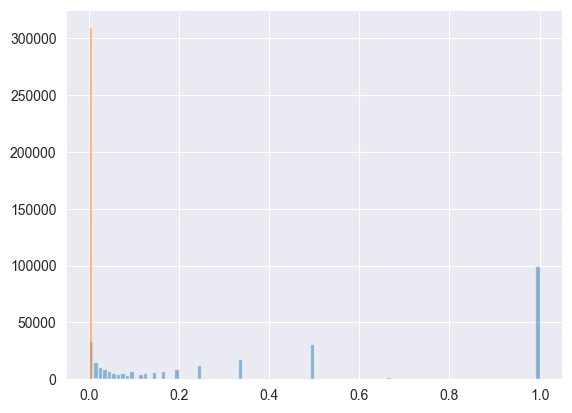

In [28]:
unsmothered_values = []
smothered_values = []

for k, v in model.items():
    unsmothered_values.extend(v.values())
    smothered_values.extend(model_smoothed[k].values())
plt.hist(unsmothered_values, alpha=0.5, label='Unsmoothed', bins=100)
plt.hist(smothered_values, alpha=0.5, label='Smoothed', bins=100)
plt.show()

<Axes: xlabel='Value', ylabel='Density'>

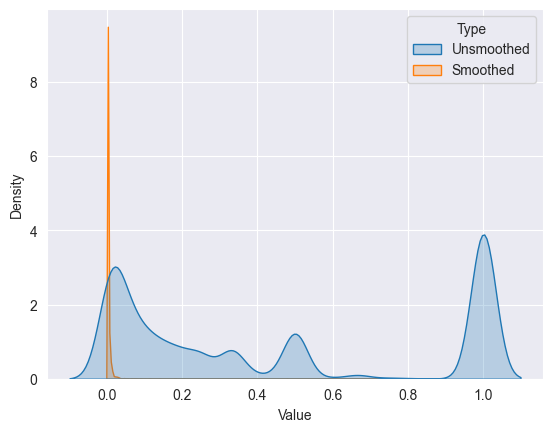

In [29]:
data = pd.DataFrame({
    'Value': unsmothered_values + smothered_values,
    'Type': ['Unsmoothed'] * len(unsmothered_values) + ['Smoothed'] * len(smothered_values)
})

sns.kdeplot(data, x='Value', hue='Type', fill=True, common_norm=False)

In [32]:
print("Unsmothered mean:", sum(unsmothered_values) / len(unsmothered_values))
print("Smothered mean:", sum(smothered_values) / len(smothered_values))
print("Unsmothered max and min:", max(unsmothered_values), min(unsmothered_values))
print("Smothered max and min:", max(smothered_values), min(smothered_values))

Unsmothered mean: 0.44410136457252286
Smothered mean: 0.0009154333890906214
Unsmothered max and min: 1.0 0.00010363768266141569
Smothered max and min: 0.7865352828989193 9.71045197740113e-05
